# Aula 1 - Introduzindo o reconhecimento de áudio

## Vídeo 1.2 - Carregando os dados

In [6]:
from pathlib import Path
home = Path.home()

gz_path = f'{home}/Documentos/dataset_commands-002.gz'

In [ ]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
import pathlib
import os
import gzip
import shutil
import numpy as np

2024-12-03 12:50:10.815657: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 12:50:10.915615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 12:50:10.915641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 12:50:10.933815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 12:50:10.967908: I tensorflow/core/platform/cpu_feature_guar

In [7]:
def le_arquivos(gz_path):
    # Diretório onde os dados serão extraídos
    extracted_path = '/tmp/dataset_commands'
    # Extrair o arquivo .gz
    with gzip.open(gz_path, 'rb') as f_in:
        with open(extracted_path + '.tar', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Extrair o arquivo .tar resultante
    shutil.unpack_archive(extracted_path + '.tar', extracted_path)

    # Caminho para os dados extraídos
    data_dir = pathlib.Path(extracted_path)

    # Listar todos os arquivos de áudio e suas labels
    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]

    # Converter caminhos para strings
    all_audio_paths = [str(path) for path in all_audio_paths]

    return all_audio_paths, all_labels

In [8]:
all_audio_paths, all_labels = le_arquivos(gz_path)

In [9]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

In [10]:
np.unique(all_labels).shape

(36,)

In [11]:
import matplotlib.pyplot as plt

In [12]:
example_audio_path = all_audio_paths[0]

In [ ]:
# Carregar o arquivo de áudio
audio_binary = tf.io.read_file(example_audio_path)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=-1)

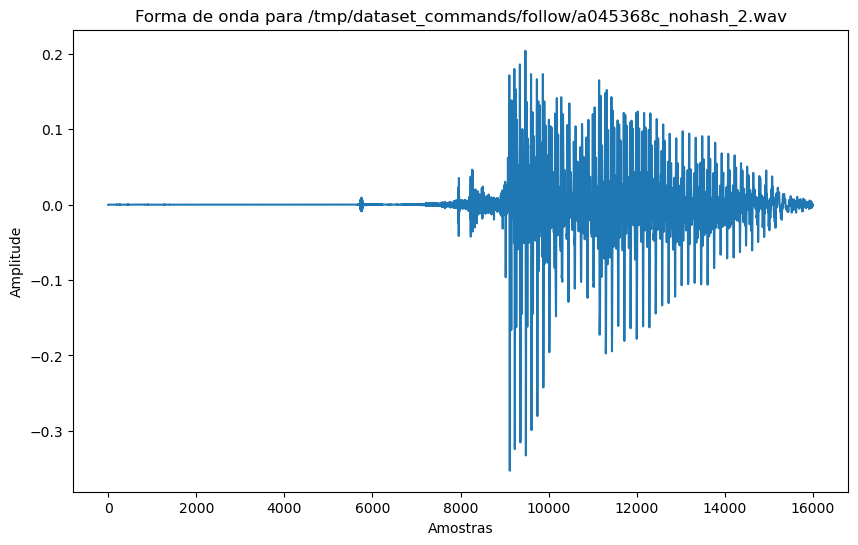

In [92]:
# Plotar a forma de onda
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

## Vídeo 1.3 - Processando os dados de áudio

In [15]:
from scipy.signal import resample


In [16]:
# Função para carregar e processar o áudio com resampling usando SciPy
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    # Função de resampling usando SciPy
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    # Usar tf.py_function para envolver a operação de resampling
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    # Adicionar padding ou cortar os sinais de áudio
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, "CONSTANT")
    
    return tf.reshape(wav, [max_length])

In [17]:
# Função para processar o caminho do arquivo de áudio e sua label
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [18]:
# Criar um dataset do TensorFlow
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
# Função para preparar o dataset para o treinamento
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [20]:
from sklearn.preprocessing import LabelEncoder
# Codificar as labels como inteiros
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [21]:
# Conjunto completo de dados
complete_dataset = paths_and_labels_to_dataset(all_audio_paths, all_labels_encoded)

## Vídeo 1.4 - Treinando a rede

In [22]:
# Dividir o dataset em treino e validação
total_size = len(all_audio_paths)
val_size = int(0.02 * total_size)
train_size = total_size - val_size

In [23]:
complete_dataset = complete_dataset.shuffle(buffer_size=total_size, seed=42)
train_dataset = complete_dataset.take(train_size)
val_dataset = complete_dataset.skip(train_size)

In [24]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

In [25]:
from tensorflow.keras import layers, models

In [26]:
# Treinamento no domínio do tempo
model_time_domain = models.Sequential([
    layers.Input(shape=(16000, 1)),
    layers.Conv1D(16, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(36, activation='softmax')
])

In [27]:
model_time_domain.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
history_time_domain = model_time_domain.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2024-12-03 12:52:02.162578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 82540 of 105835
2024-12-03 12:52:05.140131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:52:05.140840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:52:05.211313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-03 12:52:05.615709: I external/local_xla/xla/service/service.cc:168] XLA service 0x70eb888171b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-03 12:52:05.615729: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-03 12:52:05.629467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_

3242/3242 [==============================] - ETA: 0s - loss: 2.9079 - accuracy: 0.1879

2024-12-03 12:52:36.084469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83657 of 105835
2024-12-03 12:52:38.737223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:52:38.840803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 47s 10ms/step - loss: 2.9079 - accuracy: 0.1879 - val_loss: 2.4722 - val_accuracy: 0.2944
Epoch 2/10


2024-12-03 12:52:49.181450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84541 of 105835


  27/3242 [..............................] - ETA: 20s - loss: 2.4213 - accuracy: 0.2963   

2024-12-03 12:52:51.725949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:52:51.726663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3240/3242 [============================>.] - ETA: 0s - loss: 2.3913 - accuracy: 0.3129

2024-12-03 12:53:21.458489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 82845 of 105835
2024-12-03 12:53:24.249686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:53:24.347623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 2.3911 - accuracy: 0.3129 - val_loss: 2.1313 - val_accuracy: 0.3757
Epoch 3/10


2024-12-03 12:53:34.570549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85490 of 105835


  27/3242 [..............................] - ETA: 20s - loss: 2.1656 - accuracy: 0.3715   

2024-12-03 12:53:36.978974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:53:36.979659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - ETA: 0s - loss: 2.1300 - accuracy: 0.3791

2024-12-03 12:54:06.633517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85297 of 105835
2024-12-03 12:54:09.064667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:54:09.163412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 2.1300 - accuracy: 0.3791 - val_loss: 1.8575 - val_accuracy: 0.4466
Epoch 4/10


2024-12-03 12:54:19.359799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85081 of 105835


  27/3242 [..............................] - ETA: 20s - loss: 1.8831 - accuracy: 0.4525   

2024-12-03 12:54:21.821603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:54:21.822299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3240/3242 [============================>.] - ETA: 0s - loss: 1.9075 - accuracy: 0.4374

2024-12-03 12:54:51.496096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85266 of 105835
2024-12-03 12:54:53.957783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:54:54.058172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 1.9076 - accuracy: 0.4374 - val_loss: 1.6558 - val_accuracy: 0.5071
Epoch 5/10


2024-12-03 12:55:04.251419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85358 of 105835


  27/3242 [..............................] - ETA: 19s - loss: 1.6933 - accuracy: 0.5058   

2024-12-03 12:55:06.680940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:55:06.681632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3238/3242 [============================>.] - ETA: 0s - loss: 1.7078 - accuracy: 0.4921

2024-12-03 12:55:36.357031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85109 of 105835
2024-12-03 12:55:38.827982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:55:38.933459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 1.7078 - accuracy: 0.4921 - val_loss: 1.4360 - val_accuracy: 0.5898
Epoch 6/10


2024-12-03 12:55:49.158016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 86143 of 105835


  27/3242 [..............................] - ETA: 20s - loss: 1.4024 - accuracy: 0.5903   

2024-12-03 12:55:51.482347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:55:51.483053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - ETA: 0s - loss: 1.5373 - accuracy: 0.5406

2024-12-03 12:56:21.065552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85357 of 105835
2024-12-03 12:56:23.489502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:56:23.591167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 1.5373 - accuracy: 0.5406 - val_loss: 1.3629 - val_accuracy: 0.5888
Epoch 7/10


2024-12-03 12:56:33.778841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85771 of 105835


  28/3242 [..............................] - ETA: 19s - loss: 1.3038 - accuracy: 0.5971   

2024-12-03 12:56:36.229065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:56:36.229757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3241/3242 [============================>.] - ETA: 0s - loss: 1.3860 - accuracy: 0.5832

2024-12-03 12:57:05.926029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85556 of 105835
2024-12-03 12:57:08.350451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:57:08.449435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 45s 10ms/step - loss: 1.3860 - accuracy: 0.5831 - val_loss: 1.2267 - val_accuracy: 0.6347
Epoch 8/10


2024-12-03 12:57:18.622166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85429 of 105835


  27/3242 [..............................] - ETA: 19s - loss: 1.2672 - accuracy: 0.6493   

2024-12-03 12:57:21.034394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:57:21.035100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3241/3242 [============================>.] - ETA: 0s - loss: 1.2510 - accuracy: 0.6233

2024-12-03 12:57:50.171604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 88282 of 105835
2024-12-03 12:57:52.287555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:57:52.380038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 44s 10ms/step - loss: 1.2510 - accuracy: 0.6233 - val_loss: 1.0840 - val_accuracy: 0.6805
Epoch 9/10


2024-12-03 12:58:02.577375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 88477 of 105835


  28/3242 [..............................] - ETA: 18s - loss: 1.1823 - accuracy: 0.6529   

2024-12-03 12:58:04.572901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:58:04.573616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3239/3242 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.6593

2024-12-03 12:58:33.488868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 87819 of 105835
2024-12-03 12:58:35.560376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:58:35.655353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 43s 10ms/step - loss: 1.1295 - accuracy: 0.6593 - val_loss: 0.8852 - val_accuracy: 0.7405
Epoch 10/10


2024-12-03 12:58:45.846088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 88929 of 105835


  28/3242 [..............................] - ETA: 19s - loss: 0.9295 - accuracy: 0.7109   

2024-12-03 12:58:47.778332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:58:47.779033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3238/3242 [============================>.] - ETA: 0s - loss: 1.0294 - accuracy: 0.6907

2024-12-03 12:59:16.691731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 87658 of 105835
2024-12-03 12:59:18.776265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 12:59:18.869446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 43s 10ms/step - loss: 1.0295 - accuracy: 0.6906 - val_loss: 0.8636 - val_accuracy: 0.7344


In [ ]:
def plot_history(history):
    # Resumo do histórico de precisão
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    # Resumo do histórico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

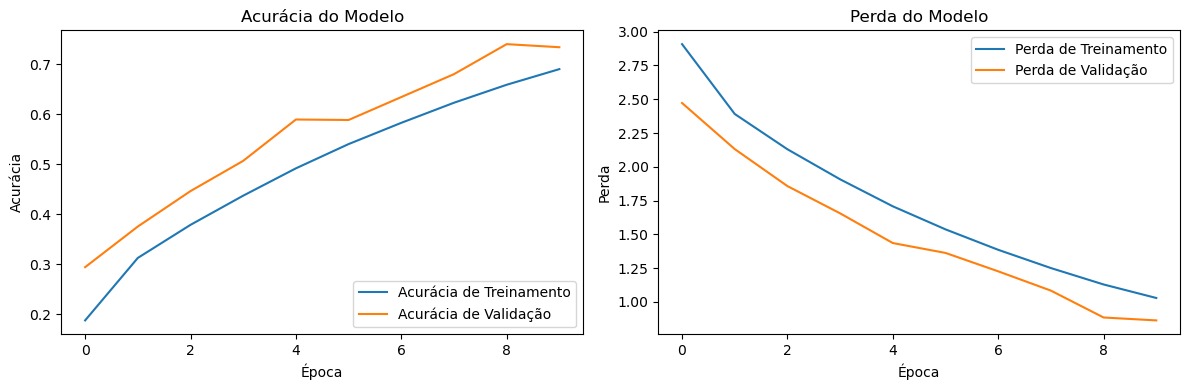

In [30]:
plot_history(history_time_domain)

# Aula 2 - Mudando o domínio

## Vídeo 2.1 - Aplicando a FFT

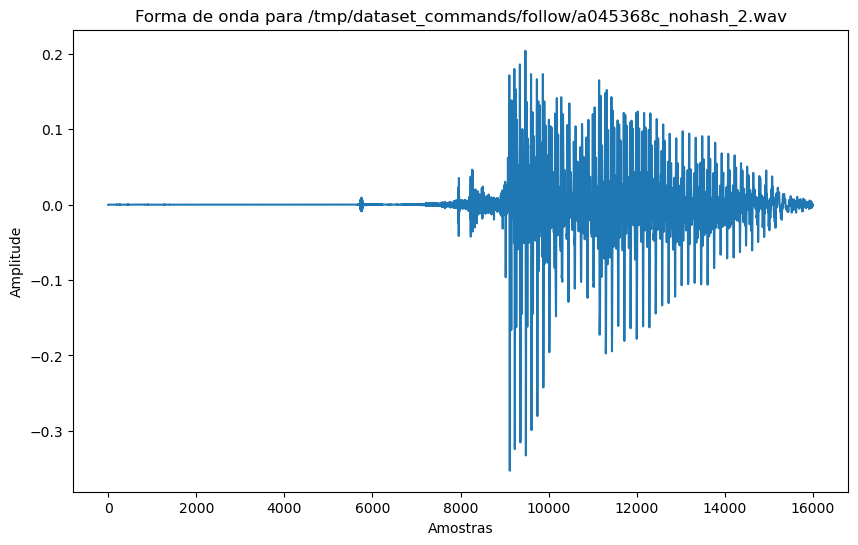

In [31]:
# Plotar a forma de onda
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def espectrograma(formadeonda):
    # Converte a forma de onda para um espectro grama usando STFT.
    espect = tf.signal.stft(
      formadeonda, frame_length=255, frame_step=128)

    espect = tf.abs(espect)

    # Adiciona uma dimensão `channels`, 
    # para que o espectrograma possa ser usado 
    # como dados de entrada semelhantes a imagens 
    # com camadas de convolução 
    # (que esperam # formato (`batch_size`, `height`, `width`, `channels`).
    espect = espect[..., tf.newaxis]
    return espect    

In [33]:
espect = espectrograma(audio.numpy())

In [34]:
def plota_espectrograma(espectrograma):
    if len(espectrograma.shape) > 2:
        assert len(espectrograma.shape) == 3
        espectrograma = np.squeeze(espectrograma, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(espectrograma.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)

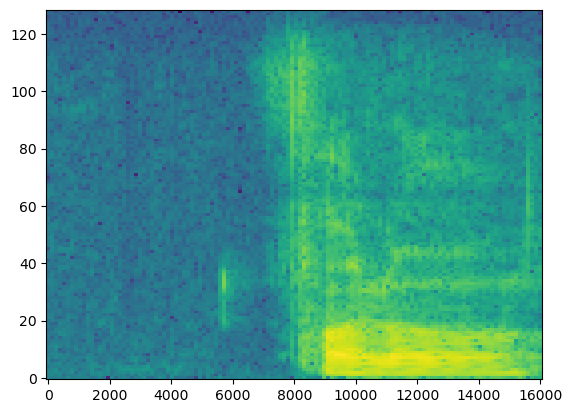

In [35]:
plota_espectrograma(espect)

## Vídeo 2.2 - Reprocessando os dados

In [36]:
def get_spectrogram_and_label_id(audio, label):
    espect = espectrograma(audio)
    return espect, label

In [37]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
# Normalize the spectrograms.
norm_layer = tf.keras.layers.Normalization()
# Get a batch of spectrograms to adapt the norm layer
for spectrogram, _ in train_spec.take(1):
    norm_layer.adapt(spectrogram)

2024-12-03 13:45:50.744199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84034 of 105835
2024-12-03 13:45:53.344856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:45:53.345579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [39]:
# Number of labels
num_labels = len(np.unique(all_labels))

In [40]:
# Get the input shape from the spectrograms
for spectrogram, _ in train_spec.take(1):
    input_shape = spectrogram.shape[1:]

2024-12-03 13:46:07.040714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84747 of 105835
2024-12-03 13:46:09.637496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:46:09.638199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


## Vídeo 2.3 - Adaptando a rede

In [41]:
input_shape

TensorShape([124, 129, 1])

In [42]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [44]:
model_spectrogram.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [45]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10


2024-12-03 13:46:18.864517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-03 13:46:28.911369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84196 of 105835
2024-12-03 13:46:31.480931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:46:31.481631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - ETA: 0s - loss: 1.8823 - accuracy: 0.4571

2024-12-03 13:46:52.761789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84274 of 105835
2024-12-03 13:46:55.343321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:46:55.445532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 37s 7ms/step - loss: 1.8823 - accuracy: 0.4571 - val_loss: 0.9814 - val_accuracy: 0.7316
Epoch 2/10


2024-12-03 13:47:05.681602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83186 of 105835


  50/3242 [..............................] - ETA: 10s - loss: 1.3089 - accuracy: 0.6125   

2024-12-03 13:47:08.375609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:47:08.376298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3235/3242 [============================>.] - ETA: 0s - loss: 1.2118 - accuracy: 0.6405

2024-12-03 13:47:28.250483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83895 of 105835
2024-12-03 13:47:31.088280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:47:31.188043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 36s 7ms/step - loss: 1.2111 - accuracy: 0.6407 - val_loss: 0.7172 - val_accuracy: 0.8157
Epoch 3/10


2024-12-03 13:47:41.385689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83700 of 105835


  51/3242 [..............................] - ETA: 10s - loss: 1.0716 - accuracy: 0.6771   

2024-12-03 13:47:44.016638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:47:44.017333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3232/3242 [============================>.] - ETA: 0s - loss: 1.0160 - accuracy: 0.6969

2024-12-03 13:48:03.841580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85175 of 105835
2024-12-03 13:48:06.275991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:48:06.376492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 1.0157 - accuracy: 0.6969 - val_loss: 0.5303 - val_accuracy: 0.8455
Epoch 4/10


2024-12-03 13:48:16.548931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84781 of 105835


  50/3242 [..............................] - ETA: 10s - loss: 0.8627 - accuracy: 0.7306   

2024-12-03 13:48:19.048577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:48:19.049281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3234/3242 [============================>.] - ETA: 0s - loss: 0.9066 - accuracy: 0.7281

2024-12-03 13:48:38.848194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 86701 of 105835
2024-12-03 13:48:41.251814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:48:41.352316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.9066 - accuracy: 0.7281 - val_loss: 0.4510 - val_accuracy: 0.8748
Epoch 5/10


2024-12-03 13:48:51.542445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84541 of 105835


  51/3242 [..............................] - ETA: 10s - loss: 0.8413 - accuracy: 0.7463   

2024-12-03 13:48:54.092045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:48:54.092767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3228/3242 [============================>.] - ETA: 0s - loss: 0.8282 - accuracy: 0.7512

2024-12-03 13:49:13.895219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85760 of 105835
2024-12-03 13:49:16.375299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:49:16.473695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.8279 - accuracy: 0.7513 - val_loss: 0.4204 - val_accuracy: 0.8833
Epoch 6/10


2024-12-03 13:49:26.662100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85983 of 105835


  51/3242 [..............................] - ETA: 10s - loss: 0.7240 - accuracy: 0.7794   

2024-12-03 13:49:28.995177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:49:28.995956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3226/3242 [============================>.] - ETA: 0s - loss: 0.7712 - accuracy: 0.7679

2024-12-03 13:49:48.805799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84879 of 105835
2024-12-03 13:49:51.307336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:49:51.405135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.7708 - accuracy: 0.7680 - val_loss: 0.3733 - val_accuracy: 0.8927
Epoch 7/10


2024-12-03 13:50:01.568534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85446 of 105835


  51/3242 [..............................] - ETA: 9s - loss: 0.7315 - accuracy: 0.7849    

2024-12-03 13:50:03.976706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:50:03.977422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3238/3242 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.7797

2024-12-03 13:50:23.770640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85207 of 105835
2024-12-03 13:50:26.252931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:50:26.353769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.7244 - accuracy: 0.7797 - val_loss: 0.3595 - val_accuracy: 0.8937
Epoch 8/10


2024-12-03 13:50:36.534871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84599 of 105835


  51/3242 [..............................] - ETA: 9s - loss: 0.6518 - accuracy: 0.8009    

2024-12-03 13:50:39.072871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:50:39.073583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3233/3242 [============================>.] - ETA: 0s - loss: 0.6966 - accuracy: 0.7883

2024-12-03 13:50:58.871120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 85928 of 105835
2024-12-03 13:51:01.232843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:51:01.331762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.6967 - accuracy: 0.7883 - val_loss: 0.3148 - val_accuracy: 0.9088
Epoch 9/10


2024-12-03 13:51:11.519563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84591 of 105835


  50/3242 [..............................] - ETA: 10s - loss: 0.6736 - accuracy: 0.7894   

2024-12-03 13:51:14.053708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:51:14.054406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3230/3242 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.7981

2024-12-03 13:51:33.847112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 86131 of 105835
2024-12-03 13:51:36.195953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:51:36.289197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 35s 7ms/step - loss: 0.6599 - accuracy: 0.7982 - val_loss: 0.2827 - val_accuracy: 0.9234
Epoch 10/10


2024-12-03 13:51:46.459016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 88320 of 105835


  52/3242 [..............................] - ETA: 9s - loss: 0.6187 - accuracy: 0.8047  

2024-12-03 13:51:48.466951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:51:48.467638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3222/3242 [============================>.] - ETA: 0s - loss: 0.6399 - accuracy: 0.8040

2024-12-03 13:52:07.855711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 87731 of 105835
2024-12-03 13:52:09.945011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 13:52:10.036297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 34s 7ms/step - loss: 0.6399 - accuracy: 0.8041 - val_loss: 0.2873 - val_accuracy: 0.9182


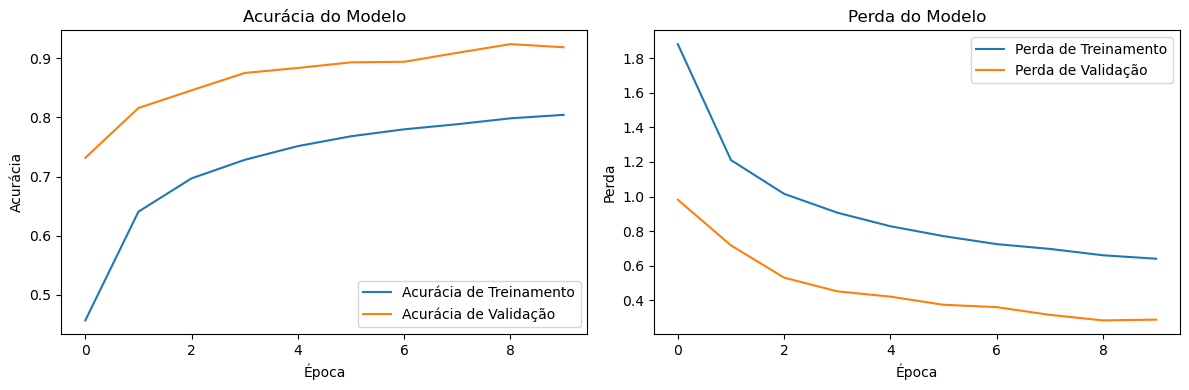

In [93]:
plot_history(history_spectrogram)

# Aula 3 - Mecanismos de atenção

## Vídeo 3.1 - Implementando uma camada de atenção de canal

Funcionamento da Camada de Atenção de Canal
A camada de atenção de canal funciona da seguinte maneira:

Pooling Global: São realizadas operações de GlobalAveragePooling2D e GlobalMaxPooling2D para obter a média e o máximo globais de cada canal, resultando em dois vetores de características representando a importância média e máxima de cada canal.

Camadas Densas: Os vetores de características são passados por duas camadas densas. A primeira camada reduz a dimensionalidade (controlada pelo parâmetro ratio), enquanto a segunda camada retorna a atenção (pesos) para cada canal.

Combinação e Aplicação de Atenção: Os vetores de atenção resultantes das operações de pooling global são combinados e aplicados aos canais de entrada originais. Isso ajusta os valores dos canais com base em sua importância calculada.

In [94]:
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.fc1 = layers.Dense(units=input_shape[-1] // self.ratio, activation='relu')
        self.fc2 = layers.Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        return inputs * out


## Vídeo 3.2 - Avaliação do modelo com atenção

In [95]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.Conv2D(64, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [96]:
model_spectrogram.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10


2024-12-03 15:21:50.692543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-03 15:22:00.781733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83066 of 105835
2024-12-03 15:22:03.533678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:22:03.534457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3236/3242 [============================>.] - ETA: 0s - loss: 1.7786 - accuracy: 0.4853

2024-12-03 15:22:30.488412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 81518 of 105835
2024-12-03 15:22:33.484292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:22:33.591525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 44s 9ms/step - loss: 1.7775 - accuracy: 0.4856 - val_loss: 0.8599 - val_accuracy: 0.7561
Epoch 2/10


2024-12-03 15:22:43.825058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 80851 of 105835


  32/3242 [..............................] - ETA: 16s - loss: 1.1119 - accuracy: 0.6611   

2024-12-03 15:22:47.074066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:22:47.074930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3238/3242 [============================>.] - ETA: 0s - loss: 1.1096 - accuracy: 0.6686

2024-12-03 15:23:12.716953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83236 of 105835
2024-12-03 15:23:15.514000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:23:15.617965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 42s 9ms/step - loss: 1.1097 - accuracy: 0.6686 - val_loss: 0.6217 - val_accuracy: 0.8181
Epoch 3/10


2024-12-03 15:23:25.841817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83266 of 105835


  31/3242 [..............................] - ETA: 16s - loss: 0.9670 - accuracy: 0.7046   

2024-12-03 15:23:28.570302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:23:28.571018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3240/3242 [============================>.] - ETA: 0s - loss: 0.9353 - accuracy: 0.7198

2024-12-03 15:23:54.540504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 81485 of 105835
2024-12-03 15:23:57.586798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:23:57.703057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 42s 9ms/step - loss: 0.9352 - accuracy: 0.7198 - val_loss: 0.4968 - val_accuracy: 0.8455
Epoch 4/10


2024-12-03 15:24:07.936238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83165 of 105835


  31/3242 [..............................] - ETA: 16s - loss: 0.8950 - accuracy: 0.7258   

2024-12-03 15:24:10.687547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:24:10.688240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3233/3242 [============================>.] - ETA: 0s - loss: 0.8401 - accuracy: 0.7453

2024-12-03 15:24:36.801968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 79974 of 105835
2024-12-03 15:24:39.978975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:24:40.086539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 42s 9ms/step - loss: 0.8400 - accuracy: 0.7453 - val_loss: 0.4323 - val_accuracy: 0.8757
Epoch 5/10


2024-12-03 15:24:50.318963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83274 of 105835


  31/3242 [..............................] - ETA: 16s - loss: 0.8088 - accuracy: 0.7560   

2024-12-03 15:24:53.057218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:24:53.057938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3241/3242 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.7664

2024-12-03 15:25:18.969086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 81370 of 105835
2024-12-03 15:25:21.959046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:25:22.065704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 42s 9ms/step - loss: 0.7673 - accuracy: 0.7664 - val_loss: 0.3961 - val_accuracy: 0.8918
Epoch 6/10


2024-12-03 15:25:32.292284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 81072 of 105835


  31/3242 [..............................] - ETA: 16s - loss: 0.6908 - accuracy: 0.7923   

2024-12-03 15:25:35.329813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:25:35.330498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3238/3242 [============================>.] - ETA: 0s - loss: 0.7174 - accuracy: 0.7799

2024-12-03 15:26:01.399136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83601 of 105835
2024-12-03 15:26:04.079865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:26:04.182159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 42s 9ms/step - loss: 0.7174 - accuracy: 0.7799 - val_loss: 0.3299 - val_accuracy: 0.9112
Epoch 7/10


2024-12-03 15:26:14.403359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83128 of 105835


  32/3242 [..............................] - ETA: 16s - loss: 0.6389 - accuracy: 0.7900   

2024-12-03 15:26:17.179117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:26:17.179831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3236/3242 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.7920

2024-12-03 15:26:42.958437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84458 of 105835
2024-12-03 15:26:45.521834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:26:45.623578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 41s 9ms/step - loss: 0.6797 - accuracy: 0.7920 - val_loss: 0.3170 - val_accuracy: 0.9078
Epoch 8/10


2024-12-03 15:26:55.850879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 83369 of 105835


  33/3242 [..............................] - ETA: 15s - loss: 0.6281 - accuracy: 0.7898   

2024-12-03 15:26:58.533776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:26:58.534505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3231/3242 [============================>.] - ETA: 0s - loss: 0.6455 - accuracy: 0.8014

2024-12-03 15:27:24.192197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84594 of 105835
2024-12-03 15:27:26.834285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:27:26.934893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 41s 9ms/step - loss: 0.6456 - accuracy: 0.8014 - val_loss: 0.3282 - val_accuracy: 0.9102
Epoch 9/10


2024-12-03 15:27:37.140485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84481 of 105835


  31/3242 [..............................] - ETA: 16s - loss: 0.6341 - accuracy: 0.8196   

2024-12-03 15:27:39.683293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:27:39.683993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3240/3242 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.8109

2024-12-03 15:28:05.410615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84050 of 105835
2024-12-03 15:28:08.026148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:28:08.139119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 41s 9ms/step - loss: 0.6137 - accuracy: 0.8108 - val_loss: 0.2938 - val_accuracy: 0.9216
Epoch 10/10


2024-12-03 15:28:18.363022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84862 of 105835


  32/3242 [..............................] - ETA: 16s - loss: 0.6271 - accuracy: 0.8145   

2024-12-03 15:28:20.857694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:28:20.858391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3239/3242 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.8166

2024-12-03 15:28:46.635010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 84063 of 105835
2024-12-03 15:28:49.233354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-03 15:28:49.334835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3242/3242 [==============================] - 41s 9ms/step - loss: 0.5925 - accuracy: 0.8166 - val_loss: 0.2623 - val_accuracy: 0.9286


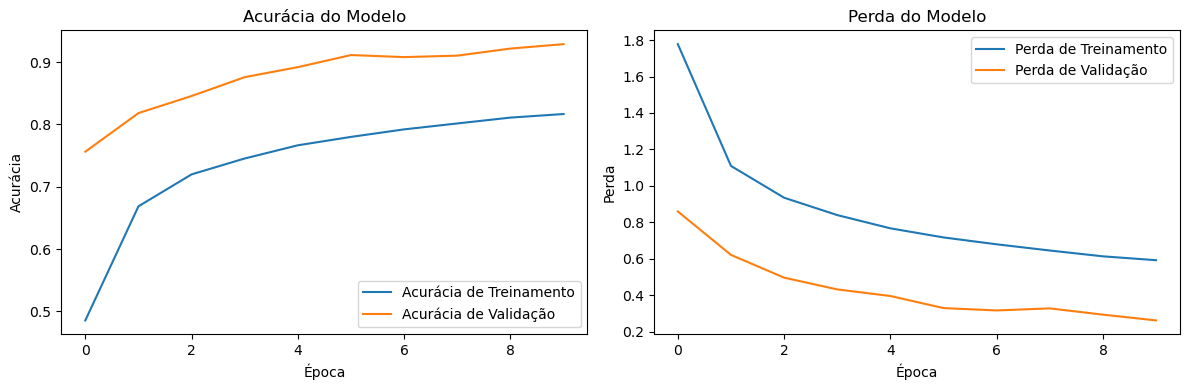

In [98]:
plot_history(history_spectrogram)

## Vídeo 3.3 - Salvando e fazendo uma inferência

In [99]:
# Caminho do arquivo específico que você quer classificar
specific_audio_path = './dados/yes.wav'

In [100]:
# Carregar e processar o áudio
specific_audio = load_and_process_audio(specific_audio_path)
specific_spectrogram = espectrograma(specific_audio.numpy())

In [101]:
# Expandir a dimensão do batch para compatibilidade com o modelo
specific_spectrogram_batch = np.expand_dims(specific_spectrogram, axis=0)

In [102]:
# Fazer a predição
specific_predictions = model_spectrogram.predict(specific_spectrogram_batch)
specific_predicted_label = np.argmax(specific_predictions, axis=-1)[0]

1/1 [==============================] - 0s 154ms/step


In [103]:
# Obter o nome da classe correspondente
predicted_class_name = label_encoder.inverse_transform([specific_predicted_label])[0]
predicted_class_name

'yes'

In [104]:
model_spectrogram.save("model_spectrogram.keras")

# Aula 4 - Trabalhando com modelos pré-treinados

## Vídeo 4.1 - Conhecendo o Yamnet

https://www.kaggle.com/models/google/yamnet

In [106]:
!pip install tensorflow_hub

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.18.0-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 70.0 MB/s eta 0:00:00m eta 0:00:010:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 66.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.0 MB/s eta 0:00:00
Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.9 MB/s eta 0:00:00
Using cached tensorboard-2.1

In [107]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import io
import os

In [108]:
tf.__version__

'2.15.0'

In [109]:
# Load the model.
model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

In [110]:
# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(3 * 16000, dtype=np.float32)

In [111]:
scores, embeddings, log_mel_spectrogram = model(waveform)

In [112]:
scores

<tf.Tensor: shape=(6, 521), dtype=float32, numpy=
array([[8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.63456e-08, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]], dtype=float32)>

In [113]:
def class_names_from_csv(class_map_csv_text):
    """Retorna uma lista de nomes de classes correspondentes ao vetor de pontuação."""
    class_map_df = pd.read_csv(io.StringIO(class_map_csv_text))
    class_names = class_map_df['display_name'].tolist()
    return class_names  

In [119]:
class_map_path = model.class_map_path().numpy()
class_map_path

b'/tmp/tfhub_modules/ef091c24975049d87464fbbd6520a6fa641eb27f/assets/yamnet_class_map.csv'

In [115]:
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
class_names


['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart murmur',
 'Cheering',
 'Applause',
 'Chatter',
 'Crowd',
 'Hubbub, speech noise, speech babble',
 'Children playing'

In [120]:
class_names[np.argmax(scores.numpy().mean(axis=0))]

'Silence'

## Vídeo 4.2 - Aplicando em diferentes tipos de áudio

In [122]:
!pip install librosa

  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00


In [123]:
import librosa

In [124]:
def load_audio(file_path):
    """
    Carrega um arquivo de áudio MP3 e retorna o waveform e a taxa de amostragem.

    Args:
    file_path (str): Caminho para o arquivo de áudio MP3.

    Returns:
    tuple: waveform (np.ndarray), sample_rate (int)
    """
    waveform, sample_rate = librosa.load(file_path, sr=None)
    return waveform, sample_rate

In [125]:
# Caminho para o arquivo barking.mp3
file_path = './dados/dog-barking-70772.mp3'

In [126]:
# Carrega o arquivo de áudio
waveform, sample_rate = load_audio(file_path)

In [127]:
import matplotlib.pyplot as plt

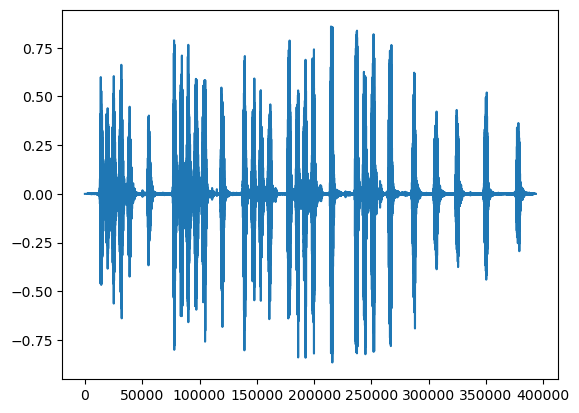

In [128]:
plt.plot(waveform)

In [129]:
scores, embeddings, log_mel_spectrogram = model(waveform)

In [130]:
class_names[np.argmax(scores.numpy().mean(axis=0))]

'Animal'

In [131]:
scores

<tf.Tensor: shape=(51, 521), dtype=float32, numpy=
array([[6.9720335e-03, 2.2417601e-04, 9.7900069e-05, ..., 2.4370605e-05,
        9.1474167e-06, 1.2725998e-08],
       [2.1340496e-04, 4.3666410e-07, 1.8599707e-07, ..., 6.5182775e-09,
        4.0466983e-08, 1.0997668e-12],
       [8.0655497e-03, 7.5857366e-05, 1.8804700e-05, ..., 1.8477343e-05,
        2.1731078e-04, 6.5534316e-09],
       ...,
       [6.7505846e-04, 4.0486038e-06, 1.9411548e-06, ..., 1.0226222e-06,
        3.2541266e-07, 1.6855535e-09],
       [4.5168046e-03, 4.6610432e-05, 3.1133401e-05, ..., 2.8437094e-05,
        8.4261337e-06, 3.6657880e-08],
       [8.2057226e-04, 3.3771933e-11, 6.8912744e-11, ..., 1.0927776e-14,
        2.5771681e-12, 5.2868637e-24]], dtype=float32)>

In [132]:
def plot_top_classes(scores, class_names, top_n=10):
    """
    Plota as top N classes mais prováveis com base nos scores.

    Args:
    scores (np.ndarray): Vetor de pontuações.
    class_names (list): Lista de nomes das classes.
    top_n (int): Número de top classes a serem visualizadas.
    """
    mean_scores = scores.mean(axis=0)
    top_indices = np.argsort(mean_scores)[-top_n:][::-1]
    top_scores = mean_scores[top_indices]
    top_class_names = [class_names[i] for i in top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_class_names, top_scores)
    plt.xlabel('Score')
    plt.ylabel('Class')
    plt.title(f'Top {top_n} Classes')
    plt.gca().invert_yaxis()
    plt.show()

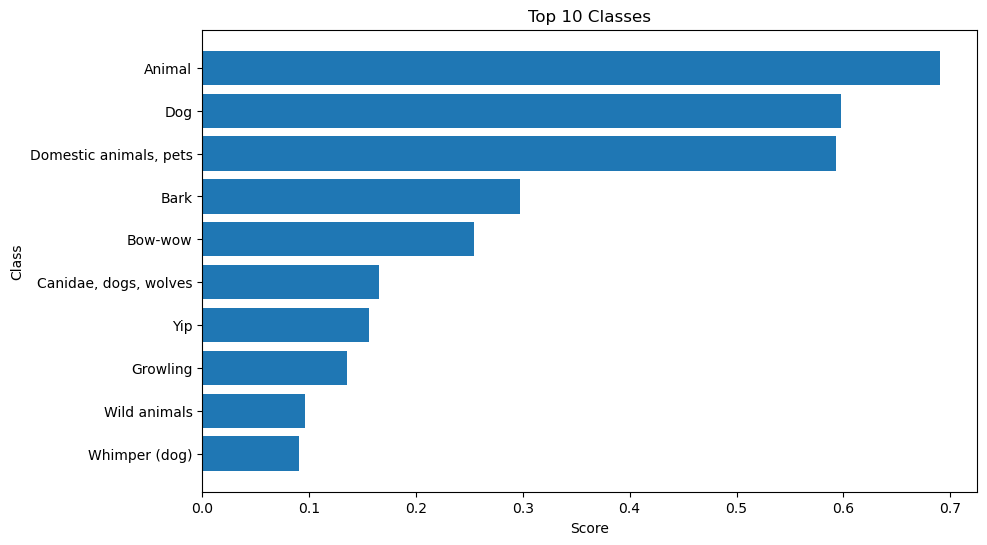

In [133]:
# Plotar as top 10 classes mais prováveis
plot_top_classes(scores.numpy(), class_names)

## Vídeo 4.3 - Obtendo um novo dataset

In [134]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir=f'{home}/',
                        cache_subdir='datasets',
                        extract=True)

   8192/Unknown - 0s 0us/step

In [135]:
esc50_csv = f'{home}/datasets/ESC-50-master/meta/esc50.csv'
base_data_path = f'{home}/datasets/ESC-50-master/audio/'

In [136]:
df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [137]:
df['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [138]:
classes = ['dog', 'door_wood_creaks', 'glass_breaking']
mapeamento = {'dog':0, 'door_wood_creaks':1,'glass_breaking':2}

In [139]:
df_filtrado = df[df['category'].isin(classes)]

In [140]:
df_filtrado

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
95,1-20133-A-39.wav,1,39,glass_breaking,False,20133,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
...,...,...,...,...,...,...,...
1971,5-257642-A-39.wav,5,39,glass_breaking,False,257642,A
1979,5-260432-A-39.wav,5,39,glass_breaking,False,260432,A
1980,5-260433-A-39.wav,5,39,glass_breaking,False,260433,A
1981,5-260434-A-39.wav,5,39,glass_breaking,False,260434,A


In [141]:
# Aplicar o mapeamento usando loc
df_filtrado.loc[:, 'alvo'] = df_filtrado['category'].apply(lambda name: mapeamento[name])

/tmp/ipykernel_6448/1854891678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:, 'alvo'] = df_filtrado['category'].apply(lambda name: mapeamento[name])


In [142]:
full_path = df_filtrado['filename'].apply(lambda row: os.path.join(base_data_path, row))
df_filtrado = df_filtrado.assign(filename=full_path)
df_filtrado

,filename,fold,target,category,esc10,src_file,take,alvo
0,/home/marcelo/datasets/ESC-50-master/audio/1-1...,1,0,dog,True,100032,A,0
14,/home/marcelo/datasets/ESC-50-master/audio/1-1...,1,0,dog,True,110389,A,0
95,/home/marcelo/datasets/ESC-50-master/audio/1-2...,1,39,glass_breaking,False,20133,A,2
157,/home/marcelo/datasets/ESC-50-master/audio/1-3...,1,0,dog,True,30226,A,0
158,/home/marcelo/datasets/ESC-50-master/audio/1-3...,1,0,dog,True,30344,A,0
...,...,...,...,...,...,...,...,...
1971,/home/marcelo/datasets/ESC-50-master/audio/5-2...,5,39,glass_breaking,False,257642,A,2
1979,/home/marcelo/datasets/ESC-50-master/audio/5-2...,5,39,glass_breaking,False,260432,A,2
1980,/home/marcelo/datasets/ESC-50-master/audio/5-2...,5,39,glass_breaking,False,260433,A,2
1981,/home/marcelo/datasets/ESC-50-master/audio/5-2...,5,39,glass_breaking,False,260434,A,2


# Aula 5 - Transferência de aprendizado

## Vídeo 5.1 - Utilizando embeddings

In [143]:
# Função para processar o caminho do arquivo de áudio, sua label e o fold
def process_path(file_path, label, fold):
    audio = load_and_process_audio(file_path)
    label = tf.cast(label, tf.int64)  # Certifique-se de que label seja int64
    fold = tf.cast(fold, tf.int64)    # Certifique-se de que fold seja int64
    return audio, label, fold


In [144]:
# Criar um dataset do TensorFlow
def paths_labels_folds_to_dataset(audio_paths, labels, folds):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    fold_ds = tf.data.Dataset.from_tensor_slices(folds)
    audio_label_fold_ds = tf.data.Dataset.zip((path_ds, label_ds, fold_ds))
    return audio_label_fold_ds.map(lambda path, label, fold: tf.py_function(
        func=process_path, inp=[path, label, fold], Tout=[tf.float32, tf.int64, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

In [145]:
# Função para preparar o dataset para o treinamento
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    #ds = ds.repeat(repeat_count)  # Adicionando o repeat
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [146]:
# Supondo que 'df' é o seu DataFrame
audio_paths = df_filtrado['filename'].tolist()
labels = df_filtrado['alvo'].tolist()
folds = df['fold'].tolist()

In [147]:
# Criar o conjunto de dados do TensorFlow a partir do DataFrame
complete_dataset = paths_labels_folds_to_dataset(audio_paths, labels, folds)



In [148]:
# Função para extrair embeddings usando o modelo YAMNet
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

In [149]:
# Extrair embeddings e desagrupar o dataset
complete_dataset = complete_dataset.map(extract_embedding).unbatch()

In [150]:
# Separar os dados em treinamento e validação com base nos folds
train_dataset = complete_dataset.filter(lambda audio, label, fold: fold < 5)  # Exemplo: folds 0-4 para treinamento
val_dataset = complete_dataset.filter(lambda audio, label, fold: fold == 5)   # Exemplo: fold 5 para validação

train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

## Vídeo 5.2 - Treinando o novo modelo

In [151]:
import tensorflow as tf
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub

# Carregar o modelo YAMNet
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Função para carregar e processar o áudio com resampling usando SciPy
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    # Função de resampling usando SciPy
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    # Usar tf.py_function para envolver a operação de resampling
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    # Adicionar padding ou cortar os sinais de áudio
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, "CONSTANT")
    
    return tf.reshape(wav, [max_length])

# Função para processar o caminho do arquivo de áudio, sua label e o fold
def process_path(file_path, label, fold):
    audio = load_and_process_audio(file_path)
    label = tf.cast(label, tf.int64)  # Certifique-se de que label seja int64
    fold = tf.cast(fold, tf.int64)    # Certifique-se de que fold seja int64
    return audio, label, fold

# Criar um dataset do TensorFlow
def paths_labels_folds_to_dataset(audio_paths, labels, folds):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    fold_ds = tf.data.Dataset.from_tensor_slices(folds)
    audio_label_fold_ds = tf.data.Dataset.zip((path_ds, label_ds, fold_ds))
    return audio_label_fold_ds.map(lambda path, label, fold: tf.py_function(
        func=process_path, inp=[path, label, fold], Tout=[tf.float32, tf.int64, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

# Função para preparar o dataset para o treinamento
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Função para extrair embeddings usando o modelo YAMNet
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# Supondo que 'df' é o seu DataFrame
audio_paths = df_filtrado['filename'].tolist()
labels = df_filtrado['alvo'].tolist()
folds = df_filtrado['fold'].tolist()

# Criar o conjunto de dados do TensorFlow a partir do DataFrame
complete_dataset = paths_labels_folds_to_dataset(audio_paths, labels, folds)

# Verificar o dataset
for audio, label, fold in complete_dataset.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label: {label}")
    print(f"Fold: {fold}")

# Extrair embeddings e desagrupar o dataset
complete_dataset = complete_dataset.map(extract_embedding).unbatch()

# Verificar o dataset após extração de embeddings
for embeddings, label, fold in complete_dataset.take(1):
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Label: {label}")
    print(f"Fold: {fold}")

# Separar os dados em treinamento e validação com base nos folds
train_dataset = complete_dataset.filter(lambda embeddings, label, fold: fold < 5)  # Exemplo: folds 1-4 para treinamento
val_dataset = complete_dataset.filter(lambda embeddings, label, fold: fold == 5)   # Exemplo: fold 5 para validação

train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

print(train_dataset.element_spec)
print(val_dataset.element_spec)

# Definir e compilar o modelo
meu_modelo = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)))  # Certifique-se de que len(classes) está correto
])

meu_modelo.summary()

meu_modelo.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Treinar o modelo
history = meu_modelo.fit(train_dataset,
                       epochs=20,
                       validation_data=val_dataset,
                       callbacks=[callback])  # Certifique-se de que o callback é passado como uma lista


Audio shape: (16000,)
Label: 0
Fold: 1
Embeddings shape: (1024,)
Label: 0
Fold: 1
(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 526339 (2.01 MB)
Trainable params: 526339 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

2024-12-03 16:07:44.356708: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13953447945035736789


6/6 [==============================] - 3s 193ms/step - loss: 1.5761 - accuracy: 0.7552 - val_loss: 1.0175 - val_accuracy: 0.9375
Epoch 2/20


2024-12-03 16:07:45.300623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8789288881526618919
2024-12-03 16:07:45.300647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13953447945035736789


1/6 [====>.........................] - ETA: 4s - loss: 0.6569 - accuracy: 0.9062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 190ms/step - loss: 0.5318 - accuracy: 0.9219 - val_loss: 0.4902 - val_accuracy: 0.9583
Epoch 3/20
1/6 [====>.........................] - ETA: 3s - loss: 0.4387 - accuracy: 0.9062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 179ms/step - loss: 0.3531 - accuracy: 0.9323 - val_loss: 0.3912 - val_accuracy: 0.9583
Epoch 4/20
1/6 [====>.........................] - ETA: 3s - loss: 0.2659 - accuracy: 0.9375WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 152ms/step - loss: 0.2580 - accuracy: 0.9479 - val_loss: 0.3803 - val_accuracy: 0.9583
Epoch 5/20
1/6 [====>.........................] - ETA: 3s - loss: 0.3475 - accuracy: 0.8750WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 175ms/step - loss: 0.1980 - accuracy: 0.9740 - val_loss: 0.3848 - val_accuracy: 0.9583
Epoch 6/20
1/6 [====>.........................] - ETA: 3s - loss: 0.1379 - accuracy: 0.9688WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 155ms/step - loss: 0.1599 - accuracy: 0.9688 - val_loss: 0.4133 - val_accuracy: 0.9583
Epoch 7/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0891 - accuracy: 0.9688WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 152ms/step - loss: 0.1272 - accuracy: 0.9740 - val_loss: 0.4414 - val_accuracy: 0.9583
Epoch 8/20
1/6 [====>.........................] - ETA: 4s - loss: 0.0771 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 175ms/step - loss: 0.1059 - accuracy: 0.9896 - val_loss: 0.4733 - val_accuracy: 0.9583
Epoch 9/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0554 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 172ms/step - loss: 0.0910 - accuracy: 0.9896 - val_loss: 0.5056 - val_accuracy: 0.9583
Epoch 10/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0939 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 153ms/step - loss: 0.0790 - accuracy: 0.9948 - val_loss: 0.5409 - val_accuracy: 0.9583
Epoch 11/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0500 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 161ms/step - loss: 0.0679 - accuracy: 1.0000 - val_loss: 0.5799 - val_accuracy: 0.9583
Epoch 12/20
1/6 [====>.........................] - ETA: 4s - loss: 0.1301 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 182ms/step - loss: 0.0575 - accuracy: 1.0000 - val_loss: 0.6149 - val_accuracy: 0.9583
Epoch 13/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0435 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 173ms/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.6554 - val_accuracy: 0.9583
Epoch 14/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0230 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 156ms/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 0.6835 - val_accuracy: 0.9583
Epoch 15/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0235 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 176ms/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.7114 - val_accuracy: 0.9583
Epoch 16/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0568 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 166ms/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.7481 - val_accuracy: 0.9583
Epoch 17/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0240 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 169ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.7775 - val_accuracy: 0.9583
Epoch 18/20
1/6 [====>.........................] - ETA: 3s - loss: 0.0305 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 176ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.8064 - val_accuracy: 0.9583
Epoch 19/20
1/6 [====>.........................] - ETA: 4s - loss: 0.0200 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 176ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.8315 - val_accuracy: 0.9583
Epoch 20/20
1/6 [====>.........................] - ETA: 4s - loss: 0.0150 - accuracy: 1.0000WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6/6 [==============================] - 2s 162ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.8594 - val_accuracy: 0.9583


## Vídeo 5.3 - Testando o modelo

In [152]:
def process_and_extract_embeddings(waveform, sample_rate, max_length=16000):
    # Função de resampling usando SciPy
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    # Usar tf.py_function para envolver a operação de resampling
    wav = tf.py_function(scipy_resample, [waveform, sample_rate], tf.float32)
    
    # Adicionar padding ou cortar os sinais de áudio
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, "CONSTANT")
    
    wav = tf.reshape(wav, [max_length])

    # Extrair embeddings usando YAMNet
    scores, embeddings, spectrogram = yamnet_model(wav)
    return embeddings

In [153]:
def predict_audio_class(file_path, model, class_map):
    # Carregar e processar o arquivo de áudio MP3
    waveform, sample_rate = load_audio(file_path)
    
    # Processar e extrair embeddings
    embeddings = process_and_extract_embeddings(waveform, sample_rate)
    
    # Fazer a inferência com o modelo treinado
    predictions = model.predict(embeddings)
    
    # Agregar as previsões (por exemplo, usando a média das previsões)
    final_prediction = np.mean(predictions, axis=0)
    predicted_class_index = np.argmax(final_prediction)
    
    # Mapear o índice previsto para o nome da classe
    predicted_class_name = class_map[predicted_class_index]
    
    return predicted_class_name

In [154]:
mapeamento = {'dog': 0, 'door_wood_creaks': 1, 'glass_breaking': 2}
mapeamento_inverso = {v: k for k, v in mapeamento.items()}


In [157]:
# Exemplo de uso
file_path = './dados/glass-hit-192119.mp3'
predicted_class = predict_audio_class(file_path, meu_modelo, mapeamento_inverso)

1/1 [==============================] - 0s 33ms/step


In [158]:
predicted_class

'glass_breaking'